Souce: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/

![Harmonic oscillator](https://benmoseley.blog/wp-content/uploads/2021/08/oscillator.gif "Harmonic oscillator")

# 1D　調和振動子（Harmonic oscillator） physics-informed neural network (PINN)

This notebook contains the code to reproduce the plots presented in my blog post ["So, what is a physics-informed neural network?"](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

Please read the post for more details!

## 問題の概要

今回の課題は調和振動子のモデルを解決したい:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~,
$$
次の初期条件
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~.
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

This problem was inspired by the following blog post: https://beltoforion.de/en/harmonic_oscillator/.

## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## Environment set up

We train the PINN using PyTorch, using the following environment set up:
```bash

conda create -n pinn python=3
conda activate pinn
conda install jupyter numpy matplotlib
conda install pytorch torchvision torchaudio -c pytorch
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from figplot import plot_result
from FCN import FCN
from oscillator import oscillator

## Generate training data

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([10, 1]) torch.Size([10, 1])


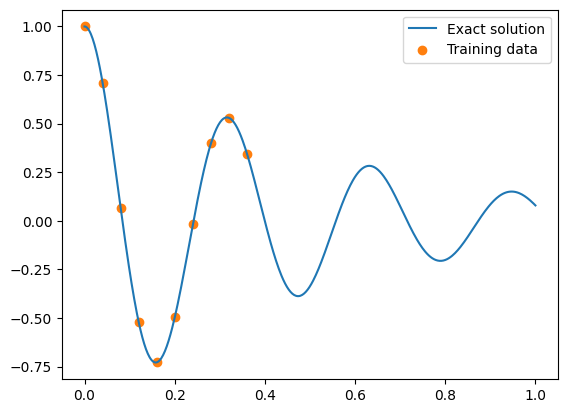

In [2]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_train = x[0:200:20]
y_train = y[0:200:20]
print(x_train.shape, y_train.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_train, y_train, color="tab:orange", label="Training data")
plt.legend()
plt.show()

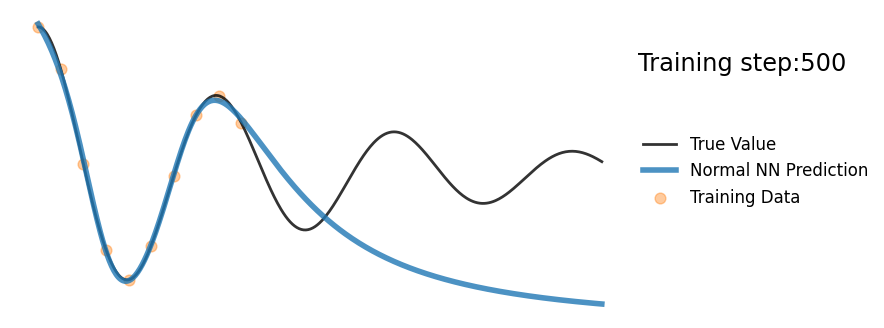

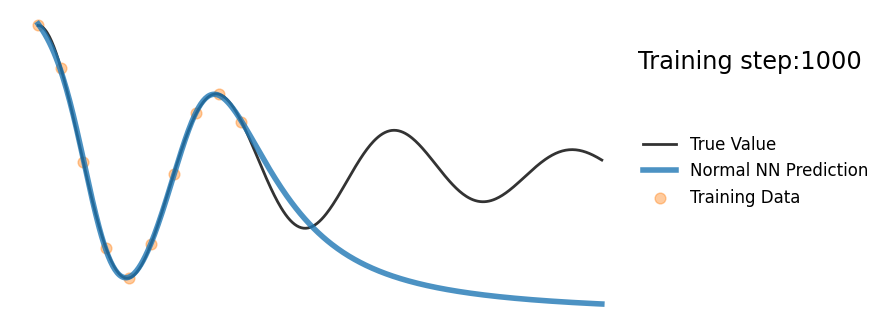

In [3]:

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

epochs = 1000

for i in range(epochs):
    optimizer.zero_grad()
    y_pre = model(x_train)
    loss = torch.mean((y_pre - y_train)**2)
    loss.backward()
    optimizer.step()
    if (i+1) % (epochs//2) ==0:
        y_pre = model(x).detach()
        plot_result(x,y,x_train,y_train,y_pre,i)
        plt.show()

## PINN


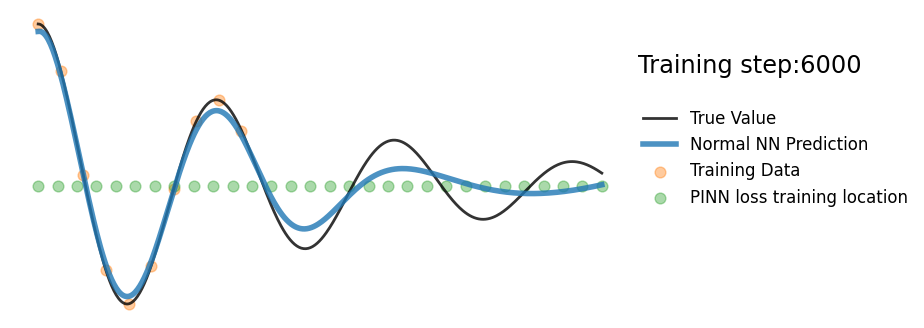

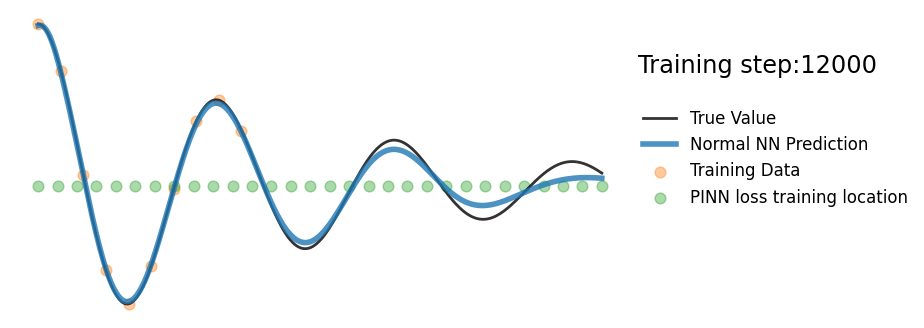

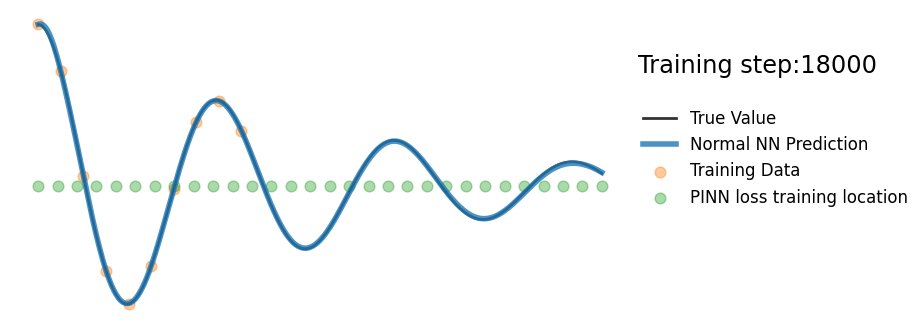

In [4]:
x_phy = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu, k = 2*d, w0**2

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
epochs = 20000
for i in range(epochs):
    optimizer.zero_grad()
    
    # compute the "data loss"
    y_pre = model(x_train)
    loss1 = torch.mean((y_pre-y_train)**2)# use mean squared error
    
    # compute the "physics loss"
    yhp = model(x_phy)
    dx  = torch.autograd.grad(yhp, x_phy, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
    dx2 = torch.autograd.grad(dx,  x_phy, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
    physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-4)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2# add two loss terms together
    loss.backward()
    optimizer.step()
    
    
    # plot the result as training progresses
    if (i+1) % 150 == 0: 
        
        yh = model(x).detach()
        xp = x_phy.detach()

        plot_result(x,y,x_train,y_train,yh,i,xp)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
    if (i+1) % 150 == 0: 
    
        yh = model(x).detach()
        xp = x_phy.detach()

        plot_result(x,y,x_train,y_train,yh,i,xp)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")